#### Running the SIDRA model for FCR estimation to compare its performance with our vehicle-specific metamodels
#### Ehsan Moradi, Ph.D. Candidate

In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

In [2]:
# General settings
VEHICLES = (
    "019 Hyundai Elantra GT 2019 (2.0L Auto)",
    "025 Chevrolet Captiva 2010 (2.4L Auto)",
    "027 Chevrolet Cruze 2011 (1.8L Manual)",
)
FEATURES = ["SPD_KH", "ACC_MS2", "ALT_M"]
DEPENDENT = "FCR_LH"
SETTINGS = {
    "INPUT_01_TYPE": "ENSEMBLE",
    "INPUT_01_INDEX": "06",
    "INPUT_02_TYPE": "SIDRA",
    "INPUT_02_INDEX": "SPECS",
    "OUTPUT_01_TYPE": "SIDRA",
    "OUTPUT_01_INDEX": "COMPARE",
}


In [3]:
# Load sample data from Excel to a pandas dataframe
def load_from_Excel(vehicle, order, sheet, settings):
    directory = (
        "../../Academia/PhD/Field Experiments/Veepeak/"
        + vehicle
        + "/Processed/"
        + settings["INPUT_" + order + "_TYPE"]
        + "/"
    )
    input_file = vehicle + " - {0} - {1}.xlsx".format(
        settings["INPUT_" + order + "_TYPE"], settings["INPUT_" + order + "_INDEX"]
    )
    input_path = directory + input_file
    df = pd.read_excel(input_path, sheet_name=sheet, header=0)
    return df


In [4]:
# Save the predicted field back to Excel file
def save_to_excel(df, vehicle, order, settings):
    directory = (
        "../../Academia/PhD/Field Experiments/Veepeak/"
        + vehicle
        + "/Processed/"
        + settings["OUTPUT_" + order + "_TYPE"]
        + "/"
    )
    output_file = vehicle + " - {0} - {1}.xlsx".format(
        settings["OUTPUT_" + order +
                 "_TYPE"], settings["OUTPUT_" + order + "_INDEX"]
    )
    output_path = directory + output_file
    with pd.ExcelWriter(output_path, engine="openpyxl", mode="w") as writer:
        df.to_excel(writer, header=True, index=None)
    print("{} -> Data is saved to Excel successfully!".format(vehicle))
    return None


In [5]:
# Calculate total tractive force (R_t)
def calculate_r_t(df, specs):
    df["R_T"] = specs["B1"] + specs["B2"] * (df["SPD_MS"] ** 2) + specs["M"] * (
        df["ACC_MS2"] / 1000) + 9.81 * (10 ** -5) * specs["M"] * df["GRADE_PERC"]
    return df


In [6]:
# Calculate fuel consumption rate
def calculate_fcr(df, specs):
    df["SIDRA_FCR_MLS"] = np.where(df['R_T'] > 0, specs["ALPHA"] + specs["BETA_1"] * df["R_T"] * df["SPD_MS"] + np.where(
        df["ACC_MS2"] > 0, specs["BETA_2"] * specs["M"] * (df["ACC_MS2"] ** 2) * df["SPD_MS"] / 1000, 0), specs["ALPHA"])
    df["SIDRA_FCR_LH"] = (3600 / 1000) * df["SIDRA_FCR_MLS"]
    return df


In [14]:
# Run the SIDRA model
predictions, observations = {}, {}
for vehicle in VEHICLES:
    df = load_from_Excel(vehicle, "01", "Sheet1", SETTINGS)
    df["SPD_MS"] = df["SPD_KH"] / 3.6
    df["GRADE_PERC"] = np.tan(np.radians(df["NO_OUTLIER_GRADE_DEG"])) * 100
    specs = load_from_Excel(VEHICLES[0], "02", "Sheet1", SETTINGS).iloc[0].to_dict()
    df = calculate_r_t(df, specs)
    df = calculate_fcr(df, specs)
    predictions[vehicle] = df["SIDRA_FCR_LH"]
    observations[vehicle] = df["FCR_LH"]
    save_to_excel(df, vehicle, "01", SETTINGS)

019 Hyundai Elantra GT 2019 (2.0L Auto) -> Data is saved to Excel successfully!
025 Chevrolet Captiva 2010 (2.4L Auto) -> Data is saved to Excel successfully!
027 Chevrolet Cruze 2011 (1.8L Manual) -> Data is saved to Excel successfully!


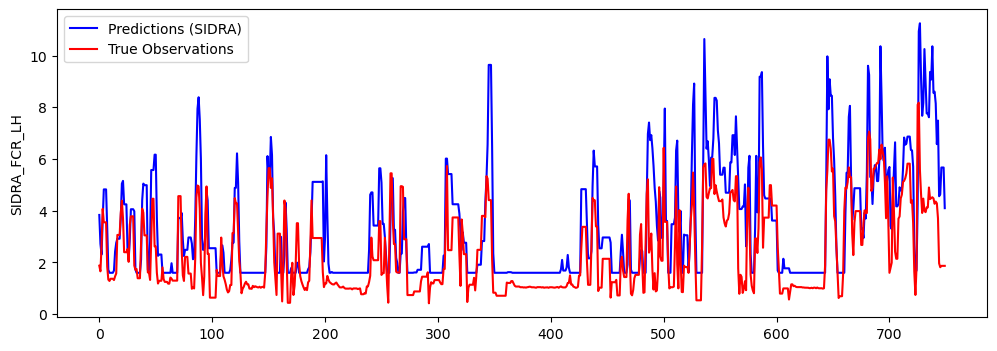

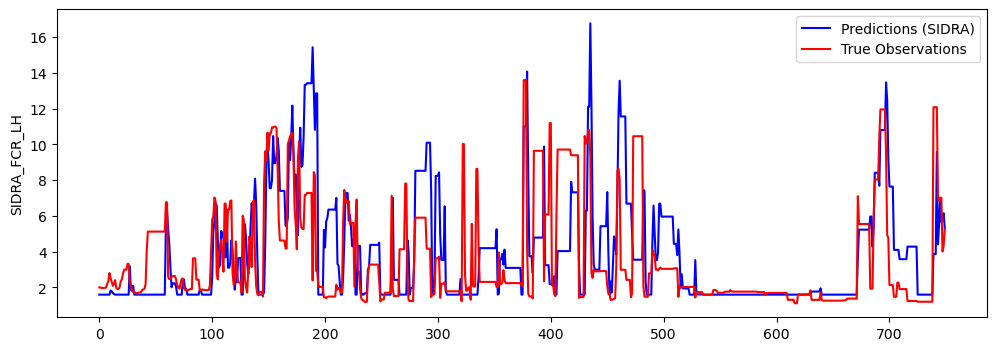

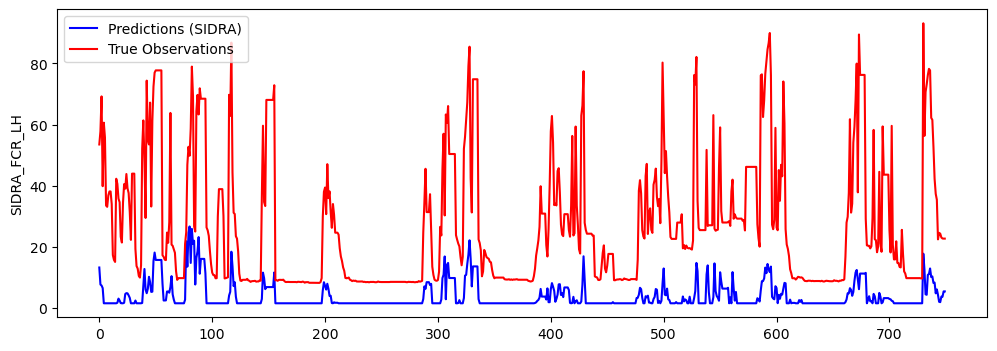

In [15]:
# Time-series plot of SIDRA predictions vs. true observations for a selected time-window
for vehicle in VEHICLES:
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.lineplot(x=range(750), y=predictions[vehicle][0:750], color="blue")
    sns.lineplot(x=range(750), y=observations[vehicle][0:750], color="red")
    plt.legend(labels=["Predictions (SIDRA)", "True Observations"])
    plt.show()

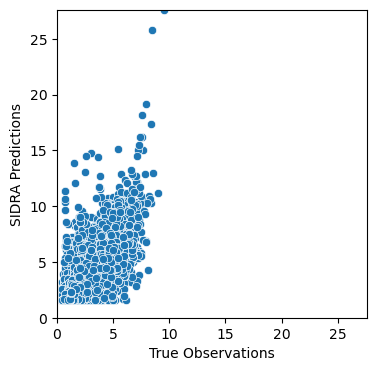

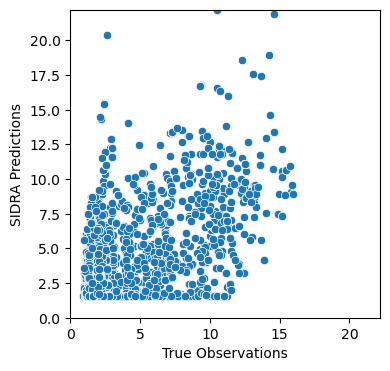

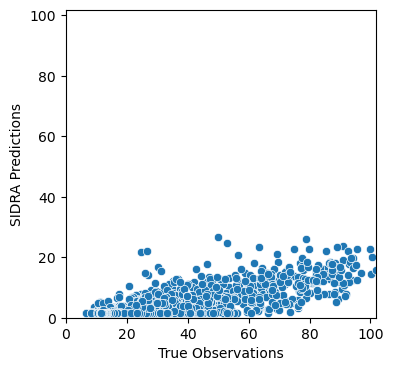

In [18]:
# Scatter plot to compare SIDRA predictions and true observations
for vehicle in VEHICLES:
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.scatterplot(x=observations[vehicle], y=predictions[vehicle])
    upper_bound = np.max([np.max(observations[vehicle]),
                         np.max(predictions[vehicle])])
    plt.xlim(0, upper_bound)
    plt.ylim(0, upper_bound)
    plt.xlabel("True Observations")
    plt.ylabel("SIDRA Predictions")
    plt.show()

In [20]:
# Calculate R-squared score
for vehicle in VEHICLES:
    print("{0}: {1}".format(vehicle, r2_score(
        observations[vehicle], predictions[vehicle])))

019 Hyundai Elantra GT 2019 (2.0L Auto): -0.06119085085590159
025 Chevrolet Captiva 2010 (2.4L Auto): 0.21640920319369228
027 Chevrolet Cruze 2011 (1.8L Manual): -1.1595217798971764
